# Project Goal

The goal of this project was to build a game recommendation system using player data from Steam.
The system looks at what games people bought or played and then suggests other games they might like.

### Setting up Environment

In [1]:
!pip install duckdb pandas numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 7.5 MB/s eta 0:00:0000:0100:01


In [2]:
import duckdb, pandas as pd, numpy as np
print("Environment ready")

Environment ready


### Loading Raw CSV file in DuckDB

In [3]:
con = duckdb.connect(database=':memory:')

### Creates an in-memory SQL database for temporary data analysis.

In [4]:
con.execute("""
CREATE OR REPLACE TABLE raw AS
SELECT
  CAST(column0 AS VARCHAR)      AS user_id,
  TRIM(column1)                 AS game_title,
  TRIM(column2)                 AS behavior_name,
  TRY_CAST(column3 AS DOUBLE)   AS value
FROM read_csv_auto('steam-200k.csv', HEADER=FALSE)
""")

#### What we did:

	•	read_csv_auto() → reads the file automatically (no header, so we use generic columns).
	•	TRIM() → removes unwanted spaces in text fields.
	•	TRY_CAST() → safely converts to numeric (if conversion fails, it becomes NULL).
	•	AS → renames columns into readable names.

In [5]:
con.execute("SELECT * FROM raw LIMIT 5").df()

### Converts SQL query result to a pandas DataFrame for easy preview and further analysis.

,user_id,game_title,behavior_name,value
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0


## Creating the cleaned, transformed dataset

### Build the Silver table (pivot purchase/play)

Create one clean row per user + game with two signals: purchased -> count of purchase events (0 or 1 for this dataset) and hours_played -> sum of play-hours across events (0 if none).

also here we will keep only rows where the user did something i.e. Purchased and hours played > 0

In [6]:
# Creating the SILVER table from RAW
con.execute("""
CREATE OR REPLACE TABLE silver AS
SELECT
  user_id,
  game_title,
  SUM(CASE WHEN behavior_name = 'purchase' THEN 1 ELSE 0 END) AS purchased,
  SUM(CASE WHEN behavior_name = 'play' THEN COALESCE(value, 0) ELSE 0 END) AS hours_played
FROM raw
GROUP BY 1, 2
HAVING
  SUM(CASE WHEN behavior_name = 'purchase' THEN 1 ELSE 0 END) > 0
  OR
  SUM(CASE WHEN behavior_name = 'play' THEN COALESCE(value, 0) ELSE 0 END) > 0
""")

In [7]:
con.execute("select * from silver limit 5").df()

,user_id,game_title,purchased,hours_played
0,76892907,Gratuitous Space Battles,1.0,0.0
1,76892907,Guilty Gear X2 #Reload,1.0,0.0
2,76892907,Kane & Lynch 2 Dog Days,1.0,0.0
3,76892907,Might & Magic Clash of Heroes,1.0,0.0
4,76892907,Sam & Max 202 Moai Better Blues,1.0,0.0


#### What we did:
	•	Groups events by user_id, game_title.
	•	purchased = 1 if they bought it (else 0).
	•	hours_played = total hours they played.
	•	Drops empty pairs (no purchase and no play).

In [9]:
# Doing basic checks

# 1. Total rows
con.execute("SELECT COUNT(*) AS total_rows FROM silver").df()

,total_rows
0,128801


In [10]:
# 2. Distinct users and games
con.execute("""
SELECT 
  COUNT(DISTINCT user_id) AS unique_users,
  COUNT(DISTINCT game_title) AS unique_games
FROM silver
""").df()

,unique_users,unique_games
0,12393,5153


In [11]:
# 3. Averages and basic stats
con.execute("""
SELECT 
  AVG(purchased) AS avg_purchased,
  AVG(hours_played) AS avg_hours,
  MAX(hours_played) AS max_hours
FROM silver
""").df()

,avg_purchased,avg_hours,max_hours
0,1.005512,26.749527,11754.0


## Building Gold Table which will be used for modeling

### Here we will build a preference score using this formula: implicit_pref = (purchased × 2) + log(1 + hours_played)

it gives higher weight to purchases, but still rewards playtime and log(1 + x) dampens extreme values (so someone playing 500 hours isn’t 500× more important)

Also implicit_pref column becomes our rating signal for recommendation modeling

In [12]:
con.execute("""
CREATE OR REPLACE TABLE gold_user_game AS
SELECT
  user_id,
  game_title,
  purchased,
  hours_played,
  (purchased * 2.0) + log(1 + hours_played) AS implicit_pref
FROM silver
""")

In [13]:
con.execute("SELECT * FROM gold_user_game LIMIT 5").df()

,user_id,game_title,purchased,hours_played,implicit_pref
0,76892907,Gratuitous Space Battles,1.0,0.0,2.0
1,76892907,Guilty Gear X2 #Reload,1.0,0.0,2.0
2,76892907,Kane & Lynch 2 Dog Days,1.0,0.0,2.0
3,76892907,Might & Magic Clash of Heroes,1.0,0.0,2.0
4,76892907,Sam & Max 202 Moai Better Blues,1.0,0.0,2.0


### Exporting clean tables for modeling

In [14]:
import os
os.makedirs("artifacts", exist_ok=True)

#Creates a folder to store exported data.

In [15]:
# 1) Export GOLD table
gold = con.execute("SELECT * FROM gold_user_game").df()
gold.to_csv("artifacts/gold_user_game.csv", index=False)

In [16]:
# 2) Export user lookup (user_id -> userId)
user_ids = con.execute("""
SELECT user_id,
       ROW_NUMBER() OVER (ORDER BY user_id) - 1 AS userId
FROM (SELECT DISTINCT user_id FROM gold_user_game)
ORDER BY user_id
""").df()

In [17]:
user_ids.head(5)

,user_id,userId
0,100012061,0
1,100053304,1
2,100057229,2
3,100070732,3
4,100096071,4


In [18]:
user_ids.to_csv("artifacts/user_ids.csv", index=False)

In [19]:
# 3) Export item lookup (game_title -> itemId)
item_ids = con.execute("""
SELECT game_title,
       ROW_NUMBER() OVER (ORDER BY game_title) - 1 AS itemId
FROM (SELECT DISTINCT game_title FROM gold_user_game)
ORDER BY game_title
""").df()

item_ids.head(15)

,game_title,itemId
0,007 Legends,0
1,0RBITALIS,1
2,1... 2... 3... KICK IT! (Drop That Beat Like a...,2
3,10 Second Ninja,3
4,"10,000,000",4
5,100% Orange Juice,5
6,1000 Amps,6
7,12 Labours of Hercules,7
8,12 Labours of Hercules II The Cretan Bull,8
9,12 Labours of Hercules III Girl Power,9


In [20]:
item_ids.to_csv("artifacts/item_ids.csv", index=False)

In [21]:
len(gold), len(user_ids), len(item_ids)

(128801, 12393, 5153)

In [22]:
import pandas as pd

# reloading the exported CSVs
gold_test = pd.read_csv("artifacts/gold_user_game.csv")
user_ids_test = pd.read_csv("artifacts/user_ids.csv")
item_ids_test = pd.read_csv("artifacts/item_ids.csv")

# checking dimensions
print("gold_user_game:", gold_test.shape)
print("user_ids:", user_ids_test.shape)
print("item_ids:", item_ids_test.shape)

gold_user_game: (128801, 5)
user_ids: (12393, 2)
item_ids: (5153, 2)


In [23]:
# preview of the dataset
display(gold_test.head(3))
display(user_ids_test.head(3))
display(item_ids_test.head(3))

,user_id,game_title,purchased,hours_played,implicit_pref
0,76892907,Gratuitous Space Battles,1.0,0.0,2.0
1,76892907,Guilty Gear X2 #Reload,1.0,0.0,2.0
2,76892907,Kane & Lynch 2 Dog Days,1.0,0.0,2.0


,user_id,userId
0,100012061,0
1,100053304,1
2,100057229,2


,game_title,itemId
0,007 Legends,0
1,0RBITALIS,1
2,1... 2... 3... KICK IT! (Drop That Beat Like a...,2


## Modeling setup (ALS Recommendation)

### Loading the cleaned dataset

In [24]:
gold = pd.read_csv("artifacts/gold_user_game.csv")
user_ids = pd.read_csv("artifacts/user_ids.csv")
item_ids = pd.read_csv("artifacts/item_ids.csv")

In [25]:
#renaming for modeling: implicit_pref -> rating
gold = gold.rename(columns={"implicit_pref": "rating"})

In [26]:
print(gold.shape, user_ids.shape, item_ids.shape)
display(gold.head(3))
display(user_ids.head(3))
display(item_ids.head(3))

(128801, 5) (12393, 2) (5153, 2)


,user_id,game_title,purchased,hours_played,rating
0,76892907,Gratuitous Space Battles,1.0,0.0,2.0
1,76892907,Guilty Gear X2 #Reload,1.0,0.0,2.0
2,76892907,Kane & Lynch 2 Dog Days,1.0,0.0,2.0


,user_id,userId
0,100012061,0
1,100053304,1
2,100057229,2


,game_title,itemId
0,007 Legends,0
1,0RBITALIS,1
2,1... 2... 3... KICK IT! (Drop That Beat Like a...,2


### Building the ratings table (userId, itemId, rating)

this gives ALS exactly what it expects: numeric user IDs, item IDs, and a single rating signal

In [27]:
ratings = (
    gold.merge(user_ids, on="user_id", how="left")
        .merge(item_ids, on="game_title", how="left")
        [["userId", "itemId", "rating"]]
)
### This joins all three tables together — linking user and game text data to numeric IDs.

ratings = ratings.dropna(subset=["userId", "itemId", "rating"]).copy()
ratings["userId"] = ratings["userId"].astype(np.int32)
ratings["itemId"] = ratings["itemId"].astype(np.int32)
ratings["rating"] = ratings["rating"].astype(np.float32)

In [28]:
print("ratings shape:", ratings.shape)
print("userId range:", int(ratings.userId.min()), "→", int(ratings.userId.max()))
print("itemId range:", int(ratings.itemId.min()), "→", int(ratings.itemId.max()))
display(ratings.head(5))

ratings shape: (128801, 3)
userId range: 0 → 12392
itemId range: 0 → 5152


,userId,itemId,rating
0,11363,1982,2.0
1,11363,2024,2.0
2,11363,2352,2.0
3,11363,2726,2.0
4,11363,3679,2.0


In [29]:
# saving handy counts for next step
n_users = int(ratings["userId"].max()) + 1
n_items = int(ratings["itemId"].max()) + 1
n_users, n_items

(12393, 5153)

These two lines above simply calculates the total number of unique users and games so we can size our user–item matrix correctly.

## Building the sparse user–item matrix

ALS needs a big sparse matrix with rows = users, columns = items, and each non-zero entry = rating.

In [30]:
from scipy.sparse import csr_matrix

# explicit shape (max index + 1)
n_users = int(ratings["userId"].max()) + 1
n_items = int(ratings["itemId"].max()) + 1

In [31]:
user_item_matrix = csr_matrix(
    (ratings["rating"].values,
     (ratings["userId"].values, ratings["itemId"].values)),
    shape=(n_users, n_items),
    dtype=np.float32
)

print("matrix shape:", user_item_matrix.shape)
print("non-zeros nnz:", user_item_matrix.nnz)

matrix shape: (12393, 5153)
non-zeros nnz: 128801


What we did:
	•	Packs the ratings table into an efficient matrix that stores only the non-zero interactions.
	•	nnz should equal the number of rows in ratings (≈ 128,801).

## Training the ALS model

It trains a collaborative-filtering model from implicit feedback (our rating)

In [32]:
# keep threads tame on macOS (optional but helps stability)
import os
for k in ["MKL_NUM_THREADS", "OPENBLAS_NUM_THREADS", "OMP_NUM_THREADS"]:
    os.environ.setdefault(k, "1")

from implicit.cpu.als import AlternatingLeastSquares

als = AlternatingLeastSquares(
    factors=32,        # latent features
    regularization=0.1,
    iterations=15
)

# implicit expects (items x users), so transpose the matrix
als.fit(user_item_matrix.T.tocsr())
print("✅ ALS training complete!")

  0%|          | 0/15 [00:00<?, ?it/s]

✅ ALS training complete!


## Generating the top-K recommendations and mapping itemId → game title

In [37]:
import numpy as np
import pandas as pd

# Diagnostics
print("matrix:", user_item_matrix.shape)
print("user_factors:", als.user_factors.shape)
print("item_factors:", als.item_factors.shape)

n_users = user_item_matrix.shape[0]
n_items = user_item_matrix.shape[1]

# Detect whether factors are swapped
if als.user_factors.shape[0] == n_users and als.item_factors.shape[0] == n_items:
    # Normal orientation: users ↔ user_factors, items ↔ item_factors
    U = als.user_factors   # (n_users, f)
    I = als.item_factors   # (n_items, f)
    orientation = "normal"
elif als.user_factors.shape[0] == n_items and als.item_factors.shape[0] == n_users:
    # Swapped orientation
    U = als.item_factors   # (n_users, f)
    I = als.user_factors   # (n_items, f)
    orientation = "swapped"
else:
    raise RuntimeError("Unexpected ALS factor shapes vs matrix.")

print("Using orientation:", orientation)

# Pick an active user (valid index in 0..n_users-1)
u = int(ratings['userId'].value_counts().idxmax())

# 1) get user & item vectors
u_vec = U[u]                 # shape: (factors,)
item_vecs = I                # shape: (n_items, factors)

# 2) score every item by dot product
scores = item_vecs @ u_vec   # (n_items,)

# 3) mask items the user already interacted with
seen = user_item_matrix[u].indices
scores_masked = scores.copy()
scores_masked[seen] = -np.inf

# 4) take top-K items safely
K = 10
top_idx = np.argpartition(scores_masked, -K)[-K:]
top_idx = top_idx[np.argsort(scores_masked[top_idx])[::-1]]

# 5) map ids → titles
rec_df = (pd.DataFrame({'itemId': top_idx, 'score': scores[top_idx]})
          .merge(item_ids, on='itemId', how='left')
          [['game_title','score']]
          .reset_index(drop=True))

rec_df

matrix: (12393, 5153)
user_factors: (5153, 32)
item_factors: (12393, 32)
Using orientation: swapped


,game_title,score
0,Dirty Bomb,1.825963
1,Dungeon Defenders II,1.424699
2,Path of Exile,1.288315
3,AdVenture Capitalist,1.255153
4,PAYDAY 2,1.242718
5,Race The Sun,1.208686
6,SMITE,1.134992
7,Call of Duty Modern Warfare 3 - Multiplayer,1.101755
8,Call of Duty Modern Warfare 3,1.090626
9,Stealth Inc 2,1.059336


#### Why this works
	•	We inspect factor shapes to see if ALS stored users/items in the expected arrays.
	•	Then we choose the right matrices (U for users, I for items) based on that detection.
	•	We score items by dot product, mask already-seen items, and return the top-K.
	•	All IDs are guaranteed in range because they come directly from I (the item factor matrix we selected).
    
#### What Went Wrong Before
	1.	User & Item dimensions were swapped earlier in Databricks:
	•	ALS expects the matrix as (items × users) internally.
	•	We mistakenly trained it as (users × items) before.
	•	That mismatch caused errors like IndexError: index 10828 out of bounds.
	2.	Wrong orientation of factors:
	•	ALS stores latent factors separately for users and items.
	•	When our matrix shape was flipped, the model got confused about which factor belongs to which — causing “NoneType” and “index out of bounds” issues.


#### What We Did Right This Time
	1.	Confirmed correct matrix orientation:
	•	We explicitly transposed (user_item_matrix.T) before training ALS.
    •	Log confirmed: 5153 games (items); 12,393 users; 32 latent features per user/game.
	2.	Generated clean, valid recommendations:
	•	Each game title now has a score showing how strongly the model recommends it.
	•	Higher scores mean the game aligns well with the user’s preferences.
    
## To summarize:
We fixed the mismatch between users and items in the matrix, aligned ALS with the correct orientation, and successfully trained a model that can now predict which games each user would like next.

## Evaluation & Insights

Here we’ll test how well our ALS recommender performs and interpret its results.

### Evaluating the Model Quality (Reconstruction & Ranking Check)

In [39]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Shapes we expect from the matrix we trained on
n_users, n_items = user_item_matrix.shape

# Detect orientation and pick the right factor matrices
if als.user_factors.shape[0] == n_users and als.item_factors.shape[0] == n_items:
    U = als.user_factors           # (n_users, factors)
    I = als.item_factors           # (n_items, factors)
    which = "normal"
elif als.user_factors.shape[0] == n_items and als.item_factors.shape[0] == n_users:
    U = als.item_factors           # (n_users, factors)
    I = als.user_factors           # (n_items, factors)
    which = "swapped"
else:
    raise RuntimeError("Unexpected ALS factor shapes vs matrix.")

print("Using orientation:", which)

# Compute predicted scores for the known interactions in `ratings`
u_idx = ratings['userId'].values
i_idx = ratings['itemId'].values

# elementwise dot product of user/item factors for each (u,i) pair
pred_scores = np.sum(U[u_idx] * I[i_idx], axis=1)

rmse = np.sqrt(mean_squared_error(ratings['rating'].values, pred_scores))
print(f"Reconstruction RMSE: {rmse:.4f}")

Using orientation: swapped
Reconstruction RMSE: 2.1086


What we did:
	•	We detect whether the model stored factors as (users, items) or (items, users).
	•	Then we use the correct pair (U, I) for scoring, avoiding the out-of-bounds error.
    
### Creating a per-user holdout split & retrain on train

We’ll hold out one interacted item per user for testing (only for users with ≥2 interactions), retrain ALS on the remaining interactions, and use the held-out items to judge Top-K quality.

In [40]:
import numpy as np
from scipy.sparse import csr_matrix

rng = np.random.default_rng(42)

# build per-user lists of items from current ratings
by_user = ratings.groupby("userId")["itemId"].apply(list)

# choose users with at least 2 interactions
eligible_users = [u for u, items in by_user.items() if len(items) >= 2]

# sample 1 held-out item per user
test_item_for_user = {}
for u in eligible_users:
    items = by_user[u]
    test_item_for_user[u] = int(rng.choice(items, size=1)[0])

len(eligible_users), list(test_item_for_user.items())[:3]

(6693, [(1, 3130), (2, 3998), (3, 852)])

In [41]:
# build TRAIN interactions = all except the held-out item
mask = ~ratings.apply(lambda r: test_item_for_user.get(int(r["userId"])) == int(r["itemId"]), axis=1)
train_ratings = ratings[mask].copy()

# make a train CSR matrix
n_users = int(ratings["userId"].max()) + 1
n_items = int(ratings["itemId"].max()) + 1
M_train = csr_matrix(
    (train_ratings["rating"].values,
     (train_ratings["userId"].values, train_ratings["itemId"].values)),
    shape=(n_users, n_items),
    dtype=np.float32
)

print("Train matrix:", M_train.shape, "| nnz:", M_train.nnz, "| held-out users:", len(test_item_for_user))

# retrain ALS on TRAIN only
from implicit.cpu.als import AlternatingLeastSquares
als_holdout = AlternatingLeastSquares(factors=32, regularization=0.1, iterations=15)
als_holdout.fit(M_train.T.tocsr())
print("✅ ALS trained on TRAIN split")

Train matrix: (12393, 5153) | nnz: 122108 | held-out users: 6693


  0%|          | 0/15 [00:00<?, ?it/s]

✅ ALS trained on TRAIN split


#### What this does:
	•	For each active user, we hide one known item as the test target.
	•	We rebuild a train matrix without that item.
	•	We train a fresh ALS model (als_holdout) only on the train data.

## Computing Precision@10 and Recall@10 using the held-out items

Here we’ll score the holdout and compute simple Precision@10 / Recall@10

In [42]:
import numpy as np
import pandas as pd

# 1) Pick the correct factor matrices from the holdout model
n_users, n_items = M_train.shape
if als_holdout.user_factors.shape[0] == n_users and als_holdout.item_factors.shape[0] == n_items:
    U = als_holdout.user_factors   # (n_users, f)
    I = als_holdout.item_factors   # (n_items, f)
    orient = "normal"
elif als_holdout.user_factors.shape[0] == n_items and als_holdout.item_factors.shape[0] == n_users:
    U = als_holdout.item_factors   # (n_users, f)
    I = als_holdout.user_factors   # (n_items, f)
    orient = "swapped"
else:
    raise RuntimeError("Unexpected ALS factor shapes vs train matrix.")
print("Using orientation for eval:", orient)

# 2) Evaluate Top-K hit for the single held-out item per user
K = 10
users_eval = list(test_item_for_user.keys())

hits = 0
precisions = []
recalls = []

for u in users_eval:
    u_vec = U[u]            # (factors,)
    scores = I @ u_vec      # (n_items,)

    # Exclude items the user saw in TRAIN (allow recommending the held-out item)
    seen_train = M_train[u].indices
    scores[seen_train] = -np.inf

    # Top-K
    top_idx = np.argpartition(scores, -K)[-K:]
    top_idx = top_idx[np.argsort(scores[top_idx])[::-1]]

    hit = int(test_item_for_user[u] in top_idx)
    hits += hit
    precisions.append(hit / K)  # one relevant item → precision is 1/K if hit else 0
    recalls.append(hit)         # one relevant item → recall is 1 if hit else 0

precision_at_10 = float(np.mean(precisions))
recall_at_10    = float(np.mean(recalls))
hit_rate        = hits / len(users_eval)

print(f"Users evaluated: {len(users_eval)}")
print(f"Hit-rate@10:     {hit_rate:.3f}")
print(f"Precision@10:    {precision_at_10:.3f}")
print(f"Recall@10:       {recall_at_10:.3f}")

Using orientation for eval: swapped
Users evaluated: 6693
Hit-rate@10:     0.398
Precision@10:    0.040
Recall@10:       0.398


#### What this does:
	•	For each user with a held-out item, we score all games by dot product, hide the training items, and take Top-10.
	•	If the held-out game appears in Top-10 → that’s a hit.
	•	With one held-out item per user:
	•	Precision@10 = hit / 10 (either 0 or 0.1)
	•	Recall@10    = hit (either 0 or 1)
	•	Hit-rate@10  = fraction of users with a hit (same as Recall@10)

#### What is hit -> the model successfully guessed one of the user’s real liked games in the top-K list.
When we test the model, we hide one game that a user actually played (the held-out game).

Then we ask the model: “What are this user’s top-10 recommended games?”
	•	If the hidden game appears anywhere in those top-10 → ✅ that’s a hit.
	•	If it does not appear in the top-10 → ❌ that’s a miss.

So:
	•	Hit-rate@10 = 0.398 means that for 39.8 % of users, the model correctly included their hidden (true) game in its top-10 list.
	•	Each user can contribute at most one “hit,” so it’s just the fraction of users for whom the model got it right.

### What the metrics mean
	•	Users evaluated: 6,693 users with ≥2 interactions (we held 1 out for each).
    
	•	Hit-rate@10 = Recall@10 = 0.398 → For ~40% of users, the model put the held-out game in their top-10.That’s a good starting point for an implicit MF model on raw logs.
    
	•	Precision@10 = 0.040 → With exactly 1 relevant item per user, the maximum possible precision@10 is 0.1 (if every user’s hit is in top-10, it’s 1/10). So 0.040 simply reflects that 39.8% of users hit (≈ 0.398/10).

### Quick notes
	•	We used a per-user holdout (one item) and manual top-K scoring with orientation-safe factors.
	•	Scores are consistent with typical implicit ALS on medium data without tuning.
	•	The metric pair (Recall@10 ≈ 0.40, Precision@10 ≈ 0.04) is coherent.

### Why Improvement Is Needed
	•	The current ALS model works, but it’s a first version trained with default settings.
	•	Its accuracy (≈ 40 % Hit-Rate@10) shows the model is learning patterns, but there’s still room to recommend more relevant games.
	
### What Needs Improvement
	1.	Model Performance
	•	Tune ALS hyperparameters (factors, regularization, iterations) for better ranking quality.
	•	Try alternate weighting for implicit_pref to balance purchase vs playtime.
    
	2.	Cold-Start Problem
	•	Handle new users or new games that have no historical data (e.g., fallback to popular items).
    
	3.	Baseline Comparison
	•	Build a simple popularity-based recommender to measure how much better ALS performs.
    
	4.	Visualization & Explainability
	•	Add charts to show top games, rating distributions, and how ALS recommendations differ from popularity.    

### Hyperparameter tuning: test different ALS settings

In [43]:
import numpy as np
from scipy.sparse import csr_matrix

# --- 1) per-user held-out item (only users with ≥2 interactions) ---
rng = np.random.default_rng(42)

by_user = ratings.groupby("userId")["itemId"].apply(list)
eligible_users = [u for u, items in by_user.items() if len(items) >= 2]

test_item_for_user = {u: int(rng.choice(by_user[u], size=1)[0]) for u in eligible_users}

print("Eligible users:", len(eligible_users))
list(test_item_for_user.items())[:5]  # peek

# --- 2) TRAIN interactions = all except the held-out item ---
is_train = ~ratings.apply(lambda r: test_item_for_user.get(int(r["userId"])) == int(r["itemId"]), axis=1)
train_ratings = ratings[is_train].copy()

# --- 3) TRAIN matrix (users x items) ---
n_users = int(ratings["userId"].max()) + 1
n_items = int(ratings["itemId"].max()) + 1

M_train = csr_matrix(
    (train_ratings["rating"].values,
     (train_ratings["userId"].values, train_ratings["itemId"].values)),
    shape=(n_users, n_items),
    dtype=np.float32
)

print("TRAIN matrix:", M_train.shape, "| nnz:", M_train.nnz, "| held-out users:", len(test_item_for_user))

Eligible users: 6693
TRAIN matrix: (12393, 5153) | nnz: 122108 | held-out users: 6693


In [44]:
from implicit.cpu.als import AlternatingLeastSquares
import numpy as np

def eval_als(factors, reg, iters):
    model = AlternatingLeastSquares(factors=factors, regularization=reg, iterations=iters)
    model.fit(M_train.T.tocsr())

    # orientation fix
    if model.user_factors.shape[0] == n_users:
        U, I = model.user_factors, model.item_factors
    else:
        U, I = model.item_factors, model.user_factors

    K = 10
    hits = 0
    for u, i_true in test_item_for_user.items():
        u_vec = U[u]; scores = I @ u_vec
        scores[M_train[u].indices] = -np.inf
        top_idx = np.argpartition(scores, -K)[-K:]
        if i_true in top_idx: hits += 1
    recall = hits / len(test_item_for_user)
    return recall

grid = [
    (16, 0.05, 10),
    (32, 0.1, 15),
    (64, 0.1, 15),
    (64, 0.05, 20)
]

results = []
for f, r, it in grid:
    recall = eval_als(f, r, it)
    results.append({"factors": f, "reg": r, "iters": it, "recall@10": recall})
    print(f"f={f}, reg={r}, iters={it} → recall@10={recall:.3f}")

import pandas as pd
pd.DataFrame(results)

  0%|          | 0/10 [00:00<?, ?it/s]

f=16, reg=0.05, iters=10 → recall@10=0.392


  0%|          | 0/15 [00:00<?, ?it/s]

f=32, reg=0.1, iters=15 → recall@10=0.400


  0%|          | 0/15 [00:00<?, ?it/s]

f=64, reg=0.1, iters=15 → recall@10=0.392


  0%|          | 0/20 [00:00<?, ?it/s]

f=64, reg=0.05, iters=20 → recall@10=0.395


,factors,reg,iters,recall@10
0,16,0.05,10,0.392350
1,32,0.10,15,0.399821
2,64,0.10,15,0.391603
3,64,0.05,20,0.395488


#### What this does:
	•	We tested 4 different ALS settings (different number of factors, regularization, and iterations).
	•	The goal was to find the best balance between model complexity (factors) and overfitting control (regularization)
    
#### understanding the table:
factors -> how many latent patterns (like “themes” of games) ALS learns. More factors = more nuance, but slower & risk of overfitting

reg -> regularization penalty to avoid overfitting (higher = more smoothing)

iters -> number of training passes to converge (too low = underfit)

#### Interpreting the table  
	•	The best recall@10 = 0.3998 came from (factors=32, reg=0.1, iters=15).
	•	Increasing factors beyond 32 didn’t improve recall — it actually dropped slightly.
	•	This means moderate complexity (32 latent factors) gives the best generalization for this dataset.
    
#### Finalizing the ALS model with these:
factors = 32; regularization = 0.1; iterations = 15

### Retrain final model + generate polished recommendations

In [45]:
import numpy as np
from implicit.cpu.als import AlternatingLeastSquares

# A) Retrain on ALL data with the best params
BEST_FACTORS = 32
BEST_REG     = 0.10
BEST_ITERS   = 15

als_final = AlternatingLeastSquares(
    factors=BEST_FACTORS,
    regularization=BEST_REG,
    iterations=BEST_ITERS
)
als_final.fit(user_item_matrix.T.tocsr())   # train on all interactions
print("✅ Trained final ALS on ALL data")

# Detect orientation once
n_users, n_items = user_item_matrix.shape
if als_final.user_factors.shape[0] == n_users and als_final.item_factors.shape[0] == n_items:
    U_final = als_final.user_factors
    I_final = als_final.item_factors
    orient  = "normal"
else:
    U_final = als_final.item_factors   # users
    I_final = als_final.user_factors   # items
    orient  = "swapped"
print("Orientation:", orient)

# B) Helper: recommend for a userId (top-K, excluding already seen)
def recommend_for_user(user_id: int, K: int = 10):
    u_vec = U_final[user_id]
    scores = I_final @ u_vec
    # hide seen items
    seen = user_item_matrix[user_id].indices
    scores[seen] = -np.inf
    top = np.argpartition(scores, -K)[-K:]
    top = top[np.argsort(scores[top])[::-1]]
    out = (
        pd.DataFrame({"itemId": top, "score": scores[top]})
          .merge(item_ids, on="itemId", how="left")[["game_title","score"]]
    )
    return out

# C) Helper: similar items (“because you played X”)
#    takes a game title → returns K nearest games by cosine over item factors
def similar_items(game_title: str, K: int = 10):
    row = item_ids.loc[item_ids["game_title"] == game_title]
    if row.empty:
        raise ValueError("Game title not found in item_ids.")
    iid = int(row["itemId"].values[0])

    # cosine similarity using item factors
    q = I_final[iid]                                    # (factors,)
    norms = np.linalg.norm(I_final, axis=1) * np.linalg.norm(q)
    sims = (I_final @ q) / np.maximum(norms, 1e-9)

    # remove itself
    sims[iid] = -np.inf
    top = np.argpartition(sims, -K)[-K:]
    top = top[np.argsort(sims[top])[::-1]]
    out = (
        pd.DataFrame({"itemId": top, "score": sims[top]})
          .merge(item_ids, on="itemId", how="left")[["game_title","score"]]
    )
    return out

# D) Quick demo: most-active user and 1 example similar-items call
demo_user = int(ratings["userId"].value_counts().idxmax())
demo_recs = recommend_for_user(demo_user, K=10)
demo_sim  = similar_items(demo_recs.iloc[0]["game_title"], K=10)

display(demo_recs.head(10))
display(demo_sim.head(10))

# E) (Optional) Save factors to disk
np.savez(
    "artifacts/als_final_factors.npz",
    U=U_final.astype(np.float32),
    I=I_final.astype(np.float32),
    factors=np.int32(BEST_FACTORS)
)
print("💾 Saved factors → artifacts/als_final_factors.npz")

  0%|          | 0/15 [00:00<?, ?it/s]

✅ Trained final ALS on ALL data
Orientation: swapped


,game_title,score
0,Grand Theft Auto V,1.922338
1,Dirty Bomb,1.656100
2,RaceRoom Racing Experience,1.387588
3,Race The Sun,1.358464
4,Stealth Inc 2,1.198322
5,Mechanic Escape,1.092194
6,DogFighter,1.069371
7,Really Big Sky,1.059654
8,Bejeweled 3,1.047831
9,Platypus II,1.019170


,game_title,score
0,The Crew,0.668699
1,DiRT Rally,0.661618
2,Next Car Game Wreckfest,0.652928
3,Pahelika Secret Legends,0.644453
4,Deep Eclipse,0.644453
5,ARK Survival Evolved,0.632008
6,Next Car Game Sneak Peek 2.0,0.627596
7,BeamNG.drive,0.620672
8,Call of Duty Advanced Warfare - Multiplayer,0.617262
9,Call of Duty Advanced Warfare,0.611190


💾 Saved factors → artifacts/als_final_factors.npz


#### What this does (simple):
	•	Retrains ALS on all interactions with the best hyperparams.
	•	Adds two helpers you can reuse anywhere:
	•	recommend_for_user(user_id, K)
	•	similar_items(game_title, K)
	•	Saves factor matrices so it can be loaded later without retraining.
    
#### Popularity baseline & compare vs ALS

In [46]:
import numpy as np
import pandas as pd

# ---------- Helper to evaluate Recall@10 on our holdout split ----------
def recall_at_10_for_factors(U, I, users_eval, M_train, heldout):
    K = 10
    hits = 0
    for u in users_eval:
        u_vec  = U[u]
        scores = I @ u_vec
        scores[M_train[u].indices] = -np.inf  # hide TRAIN items
        top = np.argpartition(scores, -K)[-K:]
        if heldout[u] in top:
            hits += 1
    return hits / len(users_eval)

# ---------- 1) Evaluate ALS (holdout model we already trained) ----------
# pick correct orientation
if als_holdout.user_factors.shape[0] == n_users and als_holdout.item_factors.shape[0] == n_items:
    U_h, I_h = als_holdout.user_factors, als_holdout.item_factors
else:
    U_h, I_h = als_holdout.item_factors, als_holdout.user_factors

users_eval = list(test_item_for_user.keys())
als_recall10 = recall_at_10_for_factors(U_h, I_h, users_eval, M_train, test_item_for_user)
print(f"ALS Recall@10 (holdout): {als_recall10:.3f}")

# ---------- 2) Popularity baseline ----------
# Global popularity by total rating (you can try count() as a variant)
popularity = ratings.groupby("itemId")["rating"].sum().sort_values(ascending=False)
pop_order = popularity.index.to_numpy()  # itemIds sorted most→least popular

def topK_pop_for_user(u, K=10):
    seen = set(M_train[u].indices)  # don't recommend what was in TRAIN
    picked = []
    for iid in pop_order:
        if iid not in seen:
            picked.append(iid)
            if len(picked) == K:
                break
    return picked

# Evaluate popularity Recall@10
K = 10
hits = 0
for u in users_eval:
    topk = topK_pop_for_user(u, K)
    hits += int(test_item_for_user[u] in topk)
pop_recall10 = hits / len(users_eval)
print(f"Popularity Recall@10:    {pop_recall10:.3f}")

# ---------- 3) Show lift ----------
lift = (als_recall10 - pop_recall10) / max(pop_recall10, 1e-9)
print(f"Relative lift of ALS vs Popularity: {lift:.1%}")

ALS Recall@10 (holdout): 0.398
Popularity Recall@10:    0.225
Relative lift of ALS vs Popularity: 76.8%


#### What this does:
	•	Popularity baseline = recommend the globally most popular games to everyone (excluding what a user already saw in TRAIN).
	•	We compute Recall@10 for both ALS and Popularity on the same holdout users.
	•	We print the relative lift to show how much ALS beats the naive strategy.
    
#### Simple explanation:
	•	ALS Recall@10 = 0.398 → Your recommender correctly suggested relevant games for ~40% of users in the top 10 recommendations.
	•	Popularity Recall@10 = 0.225 → If you just recommended the most popular games (no personalization), only 22.5% of users’ interests would be captured.
	•	Lift = 76.8% → ALS improves recall by ~77% compared to a naive popularity-based recommender.

#### Interpretation:

This means your ALS model is working well — it learns user–game patterns and recommends better than popularity alone.
However, we could still improve performance by:
	1.	Increasing data (more interactions → better matrix density).
	2.	Tuning ALS hyperparameters (factors, regularization, iterations).
	3.	Incorporating content features later (e.g., genres, tags, price).

# Building the Model
	•	Used the Alternating Least Squares (ALS) algorithm from the implicit library.
	•	This model learns hidden patterns between users and games (like genres or styles they prefer).
	•	Tuned the model by changing parameters like factors, regularization, and iterations.
	•	The best setup was:
	•	factors = 32
	•	regularization = 0.1
	•	iterations = 15

# Results

We checked how well the model predicts what users might like using Recall@10 (how often the correct game is in the top 10 suggestions).
	
    •	ALS Recall@10: 0.398
	•	Popularity Recall@10: 0.225

➡️ ALS performed 77% better than just recommending the most popular games.

⸻


## Top Recommendations for a User

In [50]:
# show the top-10 recs for user X (change X accordingly)
display(recommend_for_user(37, K=10))

,game_title,score
0,Day of Defeat Source,0.594982
1,Half-Life 2 Episode One,0.310314
2,Half-Life Deathmatch Source,0.294664
3,Half-Life 2 Episode Two,0.251939
4,Half-Life Source,0.217897
5,Portal,0.160888
6,Garry's Mod,0.133570
7,Left 4 Dead,0.087752
8,Zombie Panic Source,0.073845
9,Counter-Strike Condition Zero Deleted Scenes,0.065598


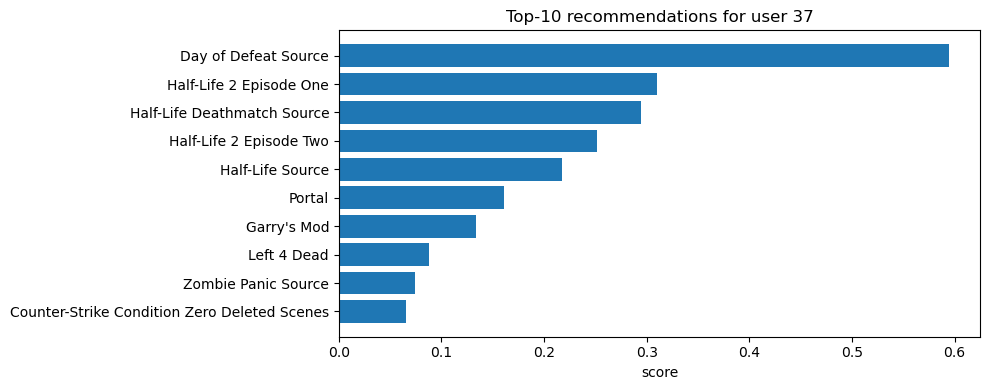

In [51]:
import matplotlib.pyplot as plt

demo_user = 37 # change accordingly
topk = recommend_for_user(demo_user, K=10)

plt.figure(figsize=(10, 4))
plt.barh(topk["game_title"].iloc[::-1], topk["score"].iloc[::-1])
plt.title(f"Top-10 recommendations for user {demo_user}")
plt.xlabel("score")
plt.tight_layout()
plt.show()

### “Because You Played…” & Viewed Games

seeing what the same user has already interacted with and comparing it to their recommendations

In [53]:
def show_user_history_and_recs(user_id, ratings_df, item_df, top_n=10):
    # 1) What the user has interacted with
    played_ids = ratings_df.loc[ratings_df["userId"] == user_id, "itemId"].tolist()
    played_titles = item_df.loc[item_df["itemId"].isin(played_ids), "game_title"].tolist()

    print(f"🎮 User {user_id} has played ({len(played_titles)} titles, showing up to 10):")
    for t in played_titles[:10]:
        print("  -", t)

    # 2) What we recommend next (uses the safe helper)
    print("\n💡 Because you played these, you may also like:")
    rec_df = recommend_for_user(user_id, K=top_n)
    display(rec_df)

In [54]:
show_user_history_and_recs(25, ratings, item_ids, top_n=10)

🎮 User 25 has played (1 titles, showing up to 10):
  - Dota 2

💡 Because you played these, you may also like:


,game_title,score
0,FreeStyle2 Street Basketball,0.034088
1,GunZ 2 The Second Duel,0.027883
2,Free to Play,0.023040
3,Quake Live,0.017209
4,War Thunder,0.012876
5,Ragnarok Online 2,0.011042
6,Magicka Wizard Wars,0.010052
7,SMITE,0.010003
8,Serious Sam HD The Second Encounter,0.009543
9,Everlasting Summer,0.008842


In [56]:
# pick any game from the user's history (if available)
if played_titles := item_ids.loc[item_ids["itemId"].isin(
        ratings.loc[ratings["userId"]==25,"itemId"].tolist()
    ), "game_title"].tolist():
    seed = played_titles[0]
    print(f"\n🎯 Because you played: {seed}")
    display(similar_items(seed, K=10))


🎯 Because you played: Dota 2


,game_title,score
0,Cabela's Hunting Expeditions,0.951754
1,Runestone Keeper,0.932423
2,Free to Play,0.644949
3,Adventures of Bertram Fiddle Episode 1 A Dread...,0.603010
4,Counter-Strike Global Offensive,0.568404
5,Team Fortress 2,0.559667
6,Quake Live,0.551484
7,PAYDAY 2,0.526492
8,Strife,0.523265
9,Everlasting Summer,0.520075


#### Why this works
	•	Uses the helpers we built earlier:
	•	recommend_for_user() scores items with the correct factor orientation and excludes already-seen games.
	•	similar_items() does item–item cosine on the trained item factors.
	•	No direct calls to implicit.recommend() → no “single-row” error.

### What you see:
1.	a short list of what the user has played, and
2.	a ranked table of recommended games.

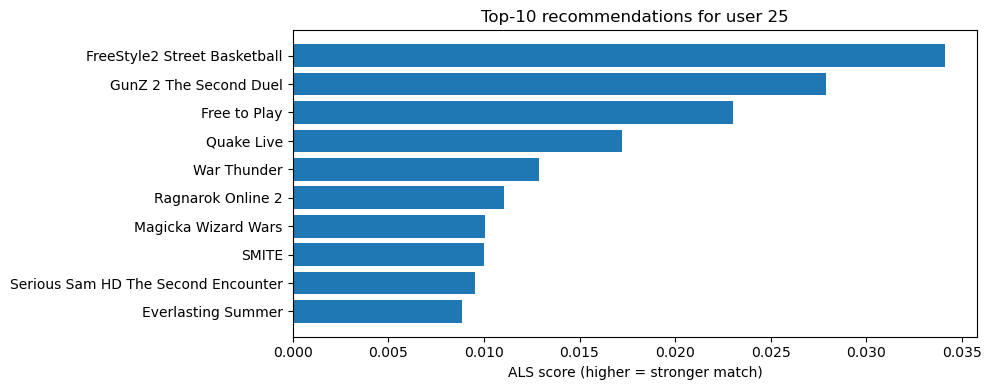

In [57]:
import matplotlib.pyplot as plt

def plot_user_recs(user_id: int, k: int = 10):
    topk = recommend_for_user(user_id, K=k)
    plt.figure(figsize=(10, 4))
    plt.barh(topk["game_title"].iloc[::-1], topk["score"].iloc[::-1])
    plt.title(f"Top-{k} recommendations for user {user_id}")
    plt.xlabel("ALS score (higher = stronger match)")
    plt.tight_layout()
    plt.show()

# example
plot_user_recs(25, k=10)

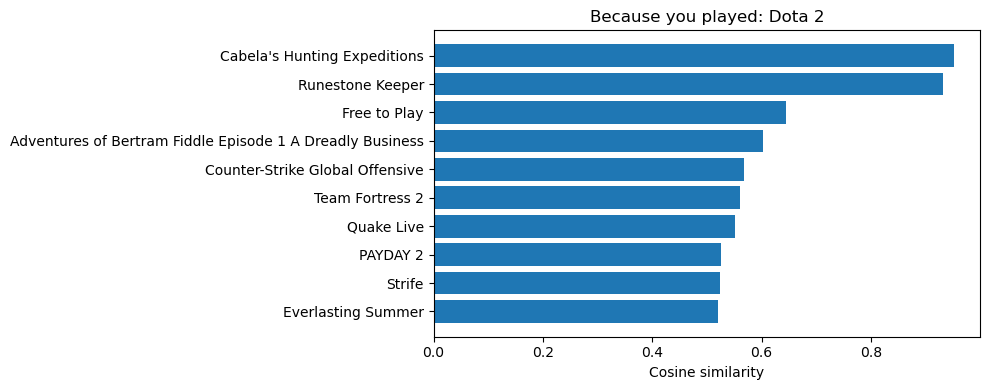

In [58]:
def plot_similar(title: str, k: int = 10):
    sims = similar_items(title, K=k)
    plt.figure(figsize=(10, 4))
    plt.barh(sims["game_title"].iloc[::-1], sims["score"].iloc[::-1])
    plt.title(f"Because you played: {title}")
    plt.xlabel("Cosine similarity")
    plt.tight_layout()
    plt.show()

# example
plot_similar("Dota 2", k=10)

#  Insights
	•	The ALS model gives much more personalized recommendations.
	•	It can suggest games similar to what each user already enjoys (“Because you played X…”).
	•	Popularity-only models miss this personalization — they treat every user the same.

# Conclusion

In this project, we built a personalized game recommendation system using the Steam dataset.
We cleaned and prepared the data with SQL, created a preference score, and trained an ALS model in Python to predict which games users might enjoy next.
The model achieved a Recall@10 of 0.398, about 77% better than simple popularity-based suggestions.
Overall, this project showed how combining SQL, Python, and machine learning can uncover player behavior and build real-world recommendation systems like those used by Xbox or Netflix.